In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.formula.api as smf

/Users/juliasbardelatti/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
df_desmatamento = pd.read_csv("../2.dados/PRODES/desmatamento_municipal/base_desmatamento_por_municipio_e_ano.csv")

In [ ]:
df_malaria = pd.read_csv("../2.dados/malaria/dados_malaria.csv")

In [8]:
df_merged = pd.merge(df_malaria, df_desmatamento, on=['codigo_municipio', 'ano', 'uf'], how='outer')
df_merged = df_merged[['codigo_municipio', 'municipio', 'ano', 'valor', 'uf', 'area_desmatada']]
df_merged.columns = ['codigo_municipio', 'nome_municipio', 'ano', 'quantidade_casos', 'uf', 'area_desmatada_km2']

In [9]:
df_merged = df_merged.sort_values(by=["codigo_municipio", "ano"])
df_merged["desmatamento_ano_anterior"] = df_merged.groupby("codigo_municipio")["area_desmatada_km2"].shift(1)
df_merged = df_merged.query("ano > 2014")

In [11]:
df_agregado = df_merged.groupby(['codigo_municipio', 'uf']).agg({
    'area_desmatada_km2': 'sum',
    'quantidade_casos': 'sum',
}).reset_index()

In [ ]:
gdf = gpd.read_file("../2.dados/ibge_malha_municipal/BR_Municipios_2024.shp")
estados_amazonia = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']
gdf_amazonia = gdf[gdf['SIGLA_UF'].isin(estados_amazonia)].copy()
gdf_amazonia["codigo_municipio"] = gdf_amazonia["CD_MUN"].astype(int)
merged = gdf_amazonia.merge(df_agregado, on="codigo_municipio", how="left")

/var/folders/gy/cxx2_pv95ys52g0qvnjgcsqm0000gn/T/ipykernel_13297/1387003366.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["lon"] = merged.geometry.centroid.x
/var/folders/gy/cxx2_pv95ys52g0qvnjgcsqm0000gn/T/ipykernel_13297/1387003366.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["lat"] = merged.geometry.centroid.y
/var/folders/gy/cxx2_pv95ys52g0qvnjgcsqm0000gn/T/ipykernel_13297/1387003366.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  estados_geom["centroid"] = estados_geom.geometry.centroid


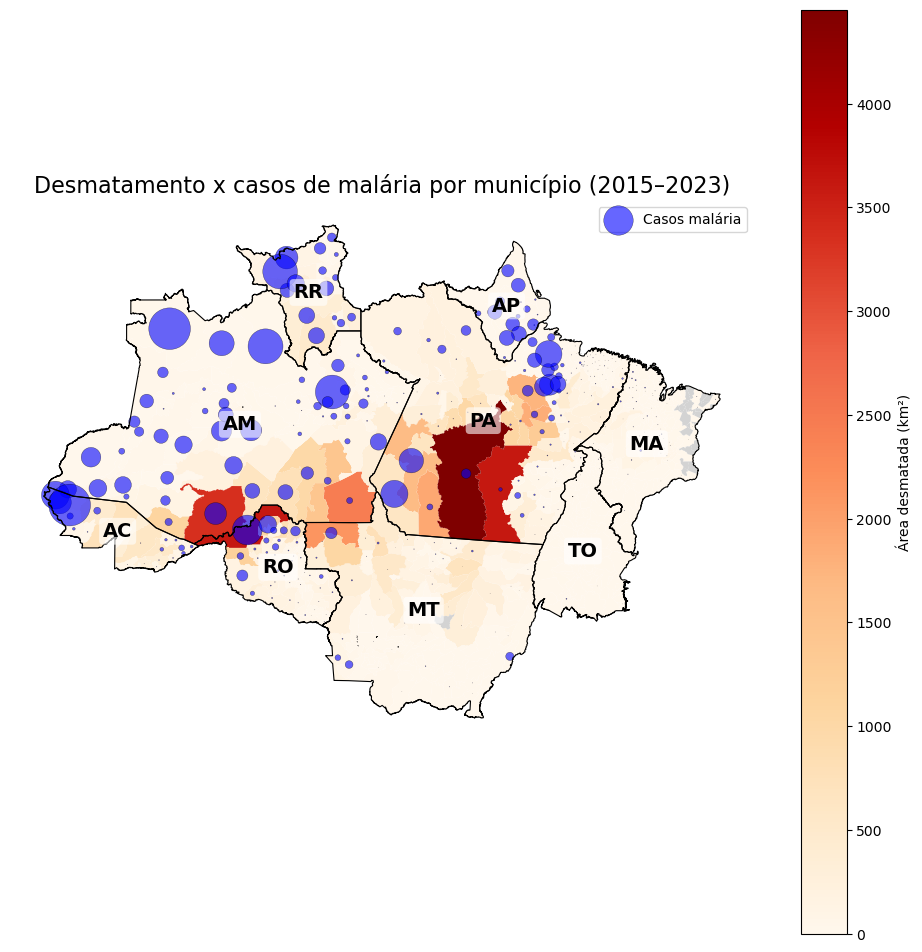

In [14]:
merged["lon"] = merged.geometry.centroid.x
merged["lat"] = merged.geometry.centroid.y
estados_geom = merged.dissolve(by="CD_UF")

if estados_geom.index.dtype != int:
    estados_geom.index = estados_geom.index.astype(int)

codigo_para_sigla = {
    11: "RO", 12: "AC", 13: "AM", 14: "RR", 15: "PA", 16: "AP", 17: "TO",
    21: "MA", 22: "PI", 23: "CE", 24: "RN", 25: "PB", 26: "PE", 27: "AL",
    28: "SE", 29: "BA", 31: "MG", 32: "ES", 33: "RJ", 35: "SP", 41: "PR",
    42: "SC", 43: "RS", 50: "MS", 51: "MT", 52: "GO", 53: "DF"
}

estados_geom["sigla_uf"] = estados_geom.index.map(codigo_para_sigla)
estados_geom["centroid"] = estados_geom.geometry.centroid
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

merged.plot(
    column="area_desmatada_km2",
    ax=ax,
    legend=True,
    cmap="OrRd",
    legend_kwds={"label": "Área desmatada (km²)"},
    missing_kwds={"color": "lightgrey"},
)

sizes = merged["quantidade_casos"].fillna(0) * 0.01
ax.scatter(
    merged["lon"],
    merged["lat"],
    s=sizes,
    color="blue",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3,
    label="Casos malária"
)

estados_geom.boundary.plot(ax=ax, color="black", linewidth=0.8)

for idx, row in estados_geom.iterrows():
    x = row.centroid.x
    y = row.centroid.y
    sigla = row.sigla_uf
    ax.text(
        x, y, sigla,
        fontsize=14, fontweight='bold', ha='center', va='center', color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )

ax.set_title("Desmatamento x casos de malária por município (2015–2023)", fontsize=16)
ax.axis("off")
ax.legend(scatterpoints=1)
plt.show()